In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/MyDrive/clue"

Mounted at /gdrive
/gdrive/MyDrive/clue


In [2]:
# Imports
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np


In [3]:
# Other constants
DATASET_DIR = "./"
DATA_FILENAME = "extended_dataset.csv"

In [4]:
dataframe = pd.read_csv(f"{DATASET_DIR}{DATA_FILENAME}")
dataframe.sample(5)

,GAME_ID,W_PCT_home,HOME_RECORD_home,ROAD_RECORD_home,W_PCT_prev_home,HOME_RECORD_prev_home,ROAD_RECORD_prev_home,W_PCT_away,HOME_RECORD_away,ROAD_RECORD_away,W_PCT_prev_away,HOME_RECORD_prev_away,ROAD_RECORD_prev_away,WIN_PRCT_home_3g,PTS_home_3g,FG_PCT_home_3g,FT_PCT_home_3g,FG3_PCT_home_3g,AST_home_3g,REB_home_3g,WIN_PRCT_away_3g,PTS_away_3g,FG_PCT_away_3g,FT_PCT_away_3g,FG3_PCT_away_3g,AST_away_3g,REB_away_3g,WIN_PRCT_home_20g,PTS_home_20g,FG_PCT_home_20g,FT_PCT_home_20g,FG3_PCT_home_20g,AST_home_20g,REB_home_20g,WIN_PRCT_away_20g,PTS_away_20g,FG_PCT_away_20g,FT_PCT_away_20g,FG3_PCT_away_20g,AST_away_20g,REB_away_20g,SEASON,HOME_TEAM_WINS
9880,40900113,0.537,0.756098,0.317073,0.427,0.560976,0.292683,0.720,0.829268,0.609756,0.720,0.780488,0.658537,0.000000,85.000000,0.434667,0.760667,0.297667,19.000000,36.666667,1.000000,105.000000,0.499000,0.730000,0.414333,17.000000,36.333333,0.55,95.20,0.45685,0.76235,0.37855,20.60,41.30,0.85,105.80,0.49375,0.71765,0.42505,21.25,42.00,2009,0
5018,10700077,0.500,1.000000,0.333333,0.268,0.341463,0.195122,0.000,0.000000,0.000000,0.537,0.658537,0.414634,0.666667,110.666667,0.463667,0.740667,0.308000,27.333333,45.666667,0.000000,76.666667,0.409000,0.638000,0.271333,13.666667,33.000000,0.35,104.15,0.47520,0.77060,0.32820,20.00,40.90,0.30,87.60,0.45265,0.64775,0.35235,19.10,37.05,2007,1
12289,21200028,0.571,1.000000,0.250000,0.636,0.696970,0.575758,0.714,0.666667,0.750000,0.333,0.484848,0.181818,0.333333,89.666667,0.438667,0.697000,0.274667,22.333333,45.000000,0.333333,87.000000,0.406000,0.813000,0.251667,16.000000,41.000000,0.55,90.80,0.42360,0.76455,0.31700,17.50,43.95,0.40,97.95,0.43810,0.73825,0.33075,19.60,40.85,2012,1
14659,21300892,0.390,0.406250,0.370370,0.354,0.439024,0.268293,0.350,0.375000,0.321429,0.659,0.756098,0.560976,0.000000,105.333333,0.451333,0.797000,0.339667,24.000000,43.000000,0.000000,91.666667,0.398333,0.824333,0.284000,15.666667,44.666667,0.35,104.35,0.46025,0.68125,0.31620,21.50,44.45,0.30,102.10,0.46045,0.73925,0.38240,20.20,42.25,2013,1
18559,21600543,0.400,0.411765,0.388889,0.402,0.439024,0.365854,0.800,0.750000,0.842105,0.817,0.975610,0.658537,0.000000,118.000000,0.479667,0.861000,0.379333,30.333333,41.666667,0.666667,110.666667,0.506000,0.812333,0.458333,27.000000,46.000000,0.40,111.05,0.47055,0.76390,0.36820,25.15,45.30,0.80,106.95,0.48860,0.80605,0.42245,24.35,44.35,2016,0


In [5]:
# Remove rows with nan values
initial_len =  len(dataframe)
dataframe.dropna(inplace=True)
print(f"{len(dataframe)}/{initial_len}")

dataframe.info()

23279/23376
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23279 entries, 1 to 23375
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GAME_ID                23279 non-null  int64  
 1   W_PCT_home             23279 non-null  float64
 2   HOME_RECORD_home       23279 non-null  float64
 3   ROAD_RECORD_home       23279 non-null  float64
 4   W_PCT_prev_home        23279 non-null  float64
 5   HOME_RECORD_prev_home  23279 non-null  float64
 6   ROAD_RECORD_prev_home  23279 non-null  float64
 7   W_PCT_away             23279 non-null  float64
 8   HOME_RECORD_away       23279 non-null  float64
 9   ROAD_RECORD_away       23279 non-null  float64
 10  W_PCT_prev_away        23279 non-null  float64
 11  HOME_RECORD_prev_away  23279 non-null  float64
 12  ROAD_RECORD_prev_away  23279 non-null  float64
 13  WIN_PRCT_home_3g       23279 non-null  float64
 14  PTS_home_3g            23279 non-null  flo

41 2 ['NO', 'YES']


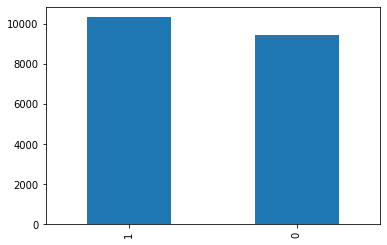

In [19]:
TARGET="HOME_TEAM_WINS"
input_size=len(dataframe.columns)-2
classes  = ["NO", "YES"]
output_size=len(classes)
print(input_size,  output_size,  classes)

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

19112/23376


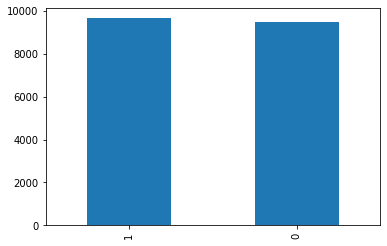

In [20]:
# Balance data

min_count = min(target.values)
max_count  = max(target.values)
remove_n = int((max_count -min_count) * 0.8)
temp = dataframe[dataframe[TARGET]==1]
drop_indices = np.random.choice(temp.index, remove_n, replace=False)

dataframe = dataframe.drop(drop_indices)

num_rows= len(dataframe)
print(f"{num_rows}/{initial_len}")

target = dataframe[TARGET].value_counts()
target.plot(kind="bar")

In [21]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop([TARGET,"GAME_ID"], axis=1).values
targets = dataframe[[TARGET]].values
inputs.shape, targets.shape

((19112, 41), (19112, 1))

Classes: 2 - ['NO', 'YES'] 
Examples: 19112
Counts: {'NO': 9469, 'YES': 9643}


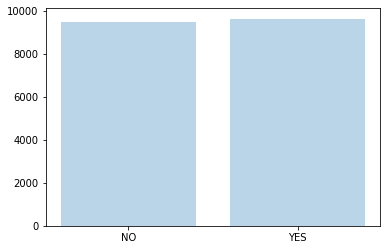

In [22]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.reshape(torch.tensor(targets,dtype=torch.int64), (-1,)))

def describe_dataset(data):
    classes_count = { c:0 for c in classes}
    for _,label in data:
        classes_count[classes[label]]+=1

    print(f'Classes: {len(classes)} - {classes} ')
    print(f'Examples: {len(data)}')
    print(f'Counts: {classes_count}')
    plt.bar(classes_count.keys(),classes_count.values(), alpha=0.3 )

    return classes_count

classes_count = describe_dataset(dataset)

In [23]:
# Split Dataset
val_percent = .15 
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

test_percent  = 0.5
test_size = int(val_size * test_percent)
val_size = val_size - test_size

val_ds, test_ds = random_split(val_ds, [val_size,  test_size])

# Hyperparameters
batch_size=128

# Create Dataloaders
train_loader = DataLoader(train_ds, batch_size)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

len(train_ds), len(val_ds) , len(test_ds)

(16246, 1433, 1433)

Classes: 2 - ['NO', 'YES'] 
Examples: 16246
Counts: {'NO': 8083, 'YES': 8163}


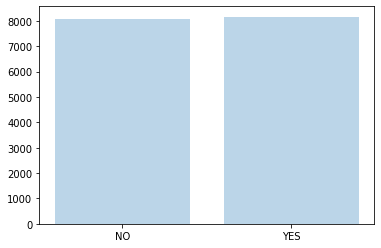

In [24]:
_ = describe_dataset(train_ds)

Classes: 2 - ['NO', 'YES'] 
Examples: 1433
Counts: {'NO': 696, 'YES': 737}


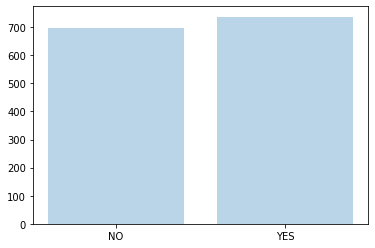

In [25]:
_ = describe_dataset(val_ds)

Classes: 2 - ['NO', 'YES'] 
Examples: 1433
Counts: {'NO': 690, 'YES': 743}


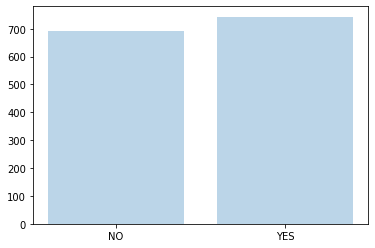

In [26]:
_ = describe_dataset(test_ds)

In [27]:
class BaseModel(nn.Module):
    def __init__(self, loss_fn=F.cross_entropy):
        super().__init__()
        self.loss_fn = loss_fn

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = self.loss_fn(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = self.loss_fn(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [28]:
class NBAModel(BaseModel):
  def __init__(self, input_size, output_size, loss_fn):
      super().__init__(loss_fn=loss_fn)
      self.network = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
            nn.ReLU(),
            nn.Linear(24, output_size),
      )
    
  def forward(self, xb):
      return self.network(xb)

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

In [54]:
model = NBAModel(input_size, output_size, loss_fn=F.cross_entropy )

In [55]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.5140038132667542, 'val_loss': 1.3646711111068726}]

In [56]:
epochs = 70
max_lr = 0.000001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [57]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                          grad_clip=grad_clip, 
                          weight_decay=weight_decay, 
                          opt_func=opt_func)

Epoch [0], last_lr: 0.00000, train_loss: 1.1806, val_loss: 0.9842, val_acc: 0.5140
Epoch [1], last_lr: 0.00000, train_loss: 0.8574, val_loss: 0.7283, val_acc: 0.5140
Epoch [2], last_lr: 0.00000, train_loss: 0.6979, val_loss: 0.6920, val_acc: 0.5196
Epoch [3], last_lr: 0.00000, train_loss: 0.6900, val_loss: 0.6920, val_acc: 0.5194
Epoch [4], last_lr: 0.00000, train_loss: 0.6901, val_loss: 0.6917, val_acc: 0.5246
Epoch [5], last_lr: 0.00000, train_loss: 0.6901, val_loss: 0.6918, val_acc: 0.5218
Epoch [6], last_lr: 0.00000, train_loss: 0.6900, val_loss: 0.6916, val_acc: 0.5246
Epoch [7], last_lr: 0.00000, train_loss: 0.6899, val_loss: 0.6909, val_acc: 0.5335
Epoch [8], last_lr: 0.00000, train_loss: 0.6897, val_loss: 0.6906, val_acc: 0.5155
Epoch [9], last_lr: 0.00000, train_loss: 0.6895, val_loss: 0.6909, val_acc: 0.5214
Epoch [10], last_lr: 0.00000, train_loss: 0.6895, val_loss: 0.6914, val_acc: 0.5192
Epoch [11], last_lr: 0.00000, train_loss: 0.6895, val_loss: 0.6917, val_acc: 0.5205
Ep

In [58]:
test_result = evaluate(model, test_loader)
test_result

{'val_acc': 0.5404837131500244, 'val_loss': 0.688840389251709}

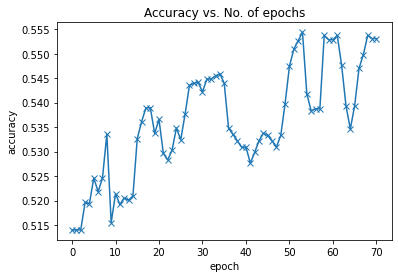

In [59]:
plot_accuracies(history)


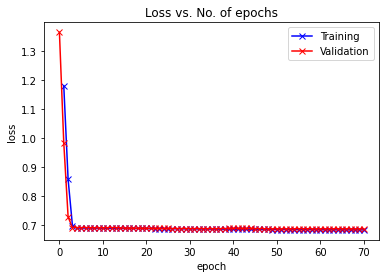

In [60]:
plot_losses(history)

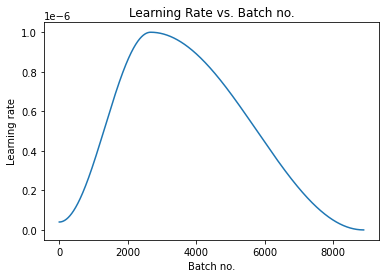

In [61]:
plot_lrs(history)

In [62]:
def predict_single(input, target, model):
    predictions = model(input) 
    _, preds = torch.max(predictions, dim=0)
    # print("Input:", input)
    print("Target:", classes[target.item()])
    print("Prediction:", classes[preds.item()])

In [63]:
input, target = test_ds[10]
predict_single(input, target, model)

Target: NO
Prediction: NO


In [64]:
input, target = test_ds[203]
predict_single(input, target, model)

Target: NO
Prediction: NO


In [65]:
input, target = test_ds[100]
predict_single(input, target, model)

Target: YES
Prediction: YES


In [66]:
torch.save(model.state_dict(), 'nba_model.pth')